## Stock Proce Forcasting with ARIMA and SARIMA

Here I built an ARIMA model and a SARIMA model to predict the next-day *adjusted close* price of a stock.  
The history data is dowload from *Yahoo! Finance*.

"Adj Close" is the closing price of the day that has been adapted, usually slightly, to include any actions before the next day’s open.

The resulting models are quite bad, the ARIMA model basically falls back to the naive persistence model (predict tomorrow's price based on today's).
Seasoning is not an important pattern here, and I add it as a practice.

In more details, the optimal orders of the ARIMA model is (0,1,0).

In [1]:
import numpy as np

import pandas as pd
import pandas_datareader as pdr

from datetime import datetime as dt

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from pmdarima.arima import ndiffs

from matplotlib import pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

/home/haowei/usr/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/home/haowei/usr/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/home/haowei/usr/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models wi

In [2]:
import os
if not os.path.exists('data'):
    os.makedirs('data')

Define some help functions here.

In [3]:
# functions to download data from Yahoo! Finance

def get_stock(ticker, start=None, end=None, fmt="%Y-%m-%d", save_csv=True):
    """download data with pandas_datareader and save it as a csv file.
       start and end should be a date string in the format as defined by fmt.
       Default will be the day 3 years before and doday."""
    
    if start is None:
        today = dt.today()
        y,m,d = today.year, today.month, today.day
        start = dt(y-3, m, d)
    else:
        start = dt.strptime(start, fmt)
        
    if end is None:
        end = dt.today()
    else:
        end = dt.strptime(end, fmt)

    data = pdr.get_data_yahoo(ticker, 
                              start=start, 
                              end=end)
    
    data.columns = [_.lower().replace(' ', '_') for _ in data.columns]
    data.index.name = 'date' # data.index.name.lower()
    
    if save_csv:
        data.to_csv('data/{}.csv'.format(ticker.lower()))
    
    return data

# sometimes we may need get multiple stocks
from functools import partial
def get_stocks(tickers, **kwargs):
    datas = map(partial(get_stock, **kwargs), tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

In [6]:
def my_plot_acf(ts, lags=30):
    # from statsmodels.graphics.tsaplots import plot_acf
    # more direct control
    fig, ax = plt.subplots(2,1,figsize=(10,6),sharex=True)
    fig = sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax[0])
    fig = sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax[1])
    plt.show()
    
def my_plot_seasonal(ts, model='multiplicative', freq=None):
    # res.plot(), again, more direct control
    res = sm.tsa.seasonal_decompose(ts, model=model, freq=freq)
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,9), sharex=True)
    
    ax[0].set_ylabel('Observed')
    res.observed.plot(ax=ax[0])
    ax[1].set_ylabel('Trend')
    res.trend.plot(ax=ax[1])
    ax[2].set_ylabel('Seasonal')
    res.seasonal.plot(ax=ax[2])
    ax[3].set_ylabel('Residual')
    res.resid.plot(ax=ax[3])
    
    plt.show()
    
    return res

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','#Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return dfoutput
    
def forecast_metrics(y_true, y_pred, algo='Algo'):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # MAPE
    smape = 200 * np.mean((np.abs(y_pred - y_true)
                    / (np.abs(y_pred) + np.abs(y_true))))
    corr = np.corrcoef(y_pred, y_true)[0,1]   # corr
    mins = np.amin(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    maxs = np.amax(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    minmax = 100*(1 - np.mean(mins/maxs))             # minmax
    return pd.DataFrame({'RMSE': rmse,
                         'MAPE': mape,
                         'SMAPE': smape,
                         'MinMax': minmax,
                         'Corr': corr
                        }, index=[algo]
          )


def plot_forcast_one_step(data, ntrain, predictions):
    plt.figure(figsize=(12,7))
    plt.plot(data.index[:ntrain], data[:ntrain], color='k', label='Train')
    plt.plot(data.index[ntrain:], data[ntrain:], color='red', label='Test')
    plt.plot(data.index[ntrain:], predictions, color='green', marker='x', linestyle='dashed',label='Forcast')
    plt.legend()
    #plt.title('Prediction')
    plt.xlabel(data.index.name.title()) 
    plt.ylabel(data.name.title())
    plt.legend()
    plt.show()
    return

def my_auto_arima(data, ntrain, pm_kwargs, nstep=1):
    
    print("# --1-- Using pm.auto_arima to find the model orders")
    model_pm = pm.auto_arima(data[:ntrain], **pm_kwargs)
    
    print(model_pm.summary())
    model_pm.plot_diagnostics(figsize=(16,8))
    plt.show();
    
    print("# --2-- build arima/sarima models and make one-step forcasting")

    ndata = len(data)
    ntest = ndata - ntrain
    
    predictions = np.zeros(ntest)
    for t in range(ntest):
        if model_pm.seasonal_order:
            model = SARIMAX(data[t:t+ntrain], order=model_pm.order, seasonal_order=model_pm.seasonal_order, trend='c' )
            model_fit = model.fit(disp=0)
        else:
            model = ARIMA(data[t:t+ntrain], order=model_pm.order)  # history has the same length
            model_fit = model.fit(disp=0, trend='c')
        if nstep==1:
            if model_pm.seasonal_order:
                yhat = model_fit.forecast().values
            else:
                yhat = model_fit.forecast()[0] # one-step forcast
            predictions[t] = yhat[0] # yhat has shape (1,) 
        else:
            pass

    
    print(model_fit.summary())
    
    print("# --3-- Plot Forcasting")
    plot_forcast_one_step(data, ntrain, predictions)

    print("# --4-- Model Evaluation")
    model_evaluation = forecast_metrics(data[ntrain:].values, predictions)
    print(model_evaluation)
    return model_fit, model_evaluation

In [7]:
# # testing get_stocks
# fang = "FB AMZN AAPL NFLX GOOG".split()
# fang_data = get_stocks(fang, start='2016-11-24', end='2019-11-24', save_csv=False)
# fang_data
# aapl = fang_data.loc['AAPL']

In [8]:
#I will work on FirstSolar since my work at NREL was related to solar cells.
ticker='FSLR'
data = get_stock(ticker, '2014-01-01', '2019-11-24')

In [9]:
data.head(2)
data.tail(2)
data.describe()

,high,low,open,close,volume,adj_close
date,,,,,,
2014-01-02,57.580002,54.009998,54.279999,57.439999,5404200,57.439999
2014-01-03,58.299999,55.849998,57.590000,56.740002,4118700,56.740002


,high,low,open,close,volume,adj_close
date,,,,,,
2019-11-21,54.610001,53.419998,54.340000,53.860001,739300,53.860001
2019-11-22,54.720001,53.880001,54.099998,54.380001,720300,54.380001


,high,low,open,close,volume,adj_close
count,1485.000000,1485.000000,1485.000000,1485.000000,1.485000e+03,1485.000000
mean,54.120343,52.291852,53.223003,53.185017,2.428452e+06,53.185017
std,11.759639,11.382853,11.583747,11.568669,2.162492e+06,11.568669
min,27.000000,25.559999,26.040001,26.330000,4.142000e+05,26.330000
25%,46.639999,45.000000,46.000000,45.599998,1.303900e+06,45.599998
50%,53.480000,51.709999,52.549999,52.490002,1.868400e+06,52.490002
75%,63.590000,61.520000,62.660000,62.529999,2.762400e+06,62.529999
max,81.720001,75.820000,78.110001,77.949997,3.087930e+07,77.949997


In [10]:
# for FSLR, close is always the same as *adj_close*, but this is not general
# (fang_data['close']-fang_data['adj_close']).max() is about 7

(data['close']-data['adj_close']).max()

0.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07f466aad0>,
      dtype=object)

,high,low,open,close,volume,adj_close
high,1.000000,0.996462,0.997163,0.997483,-0.065635,0.997483
low,0.996462,1.000000,0.997104,0.997438,-0.122493,0.997438
open,0.997163,0.997104,1.000000,0.994096,-0.099272,0.994096
close,0.997483,0.997438,0.994096,1.000000,-0.090933,1.000000
volume,-0.065635,-0.122493,-0.099272,-0.090933,1.000000,-0.090933
adj_close,0.997483,0.997438,0.994096,1.000000,-0.090933,1.000000


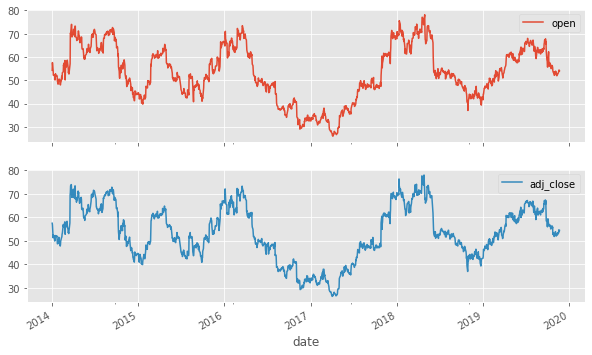

In [11]:
cols = 'open adj_close'.split()
data[cols].plot.line(figsize=(10,6), subplots=True);

data.corr()

In [12]:
# train/test splitting adn some input will be used

split = 0.8
ndata = len(data)
ntrain = int(ndata*split)
#train, test = data[:ntrain], data[ntrain:]

# some templates
auto_arima_kwargs = dict( 
                      start_p=1,
                      start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True
                    )

auto_sarima_kwargs = dict(
                      start_p=1,
                      start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=365,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True
                    )

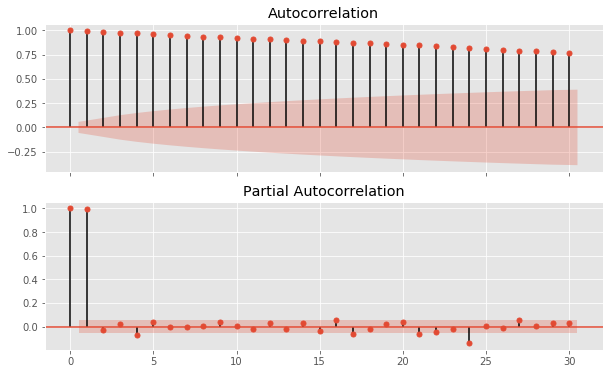

In [13]:
my_plot_acf(data[:ntrain].adj_close, lags=30)

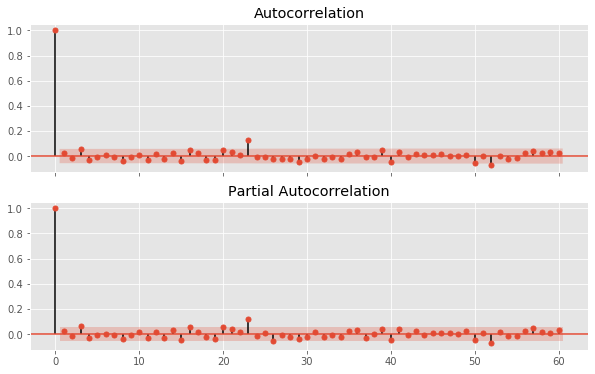

In [14]:
my_plot_acf(data[:ntrain].adj_close.diff(1).fillna(0), lags=60)

In [15]:
ndiffs(data[:ntrain].adj_close.values, alpha=0.05, test='adf', max_d=5)

1

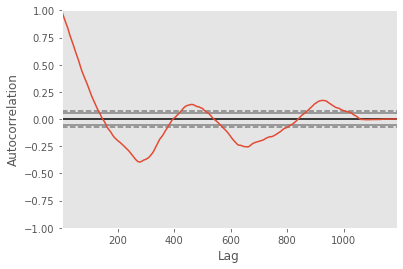

In [16]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data[:ntrain].adj_close)

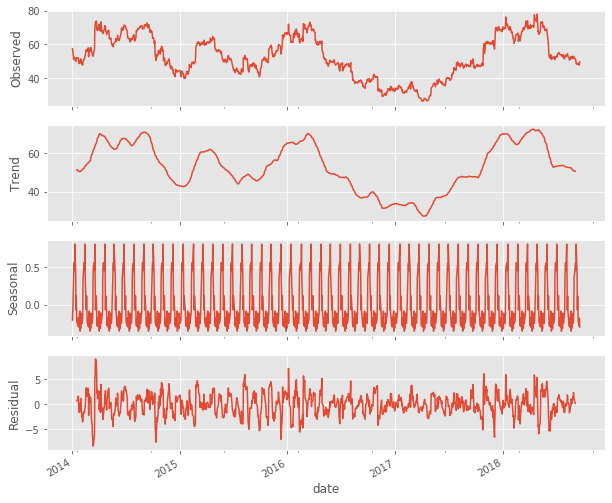

In [17]:
res_add = my_plot_seasonal(data[:ntrain].adj_close, model='additive', freq=23)

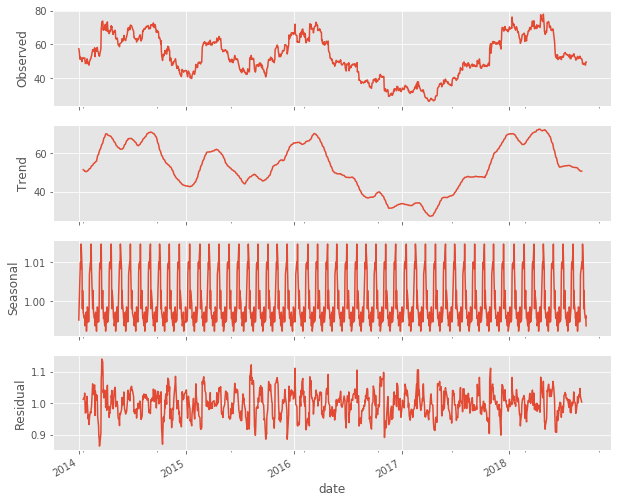

In [18]:
res_mul = my_plot_seasonal(data[:ntrain].adj_close, freq=23)

# --1-- Using pm.auto_arima to find the model orders
Fit ARIMA: order=(1, 1, 1); AIC=4361.765, BIC=4382.082, Fit time=1.105 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4358.227, BIC=4368.386, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4359.710, BIC=4374.948, Fit time=0.035 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4359.692, BIC=4374.929, Fit time=0.017 seconds
Total fit time: 1.171 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1187
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2177.114
Method:                           css   S.D. of innovations              1.515
Date:                Thu, 18 Jun 2020   AIC                           4358.227
Time:                        09:49:57   BIC                           4368.386
Sample:                             1   HQIC                          4362.056
                                                

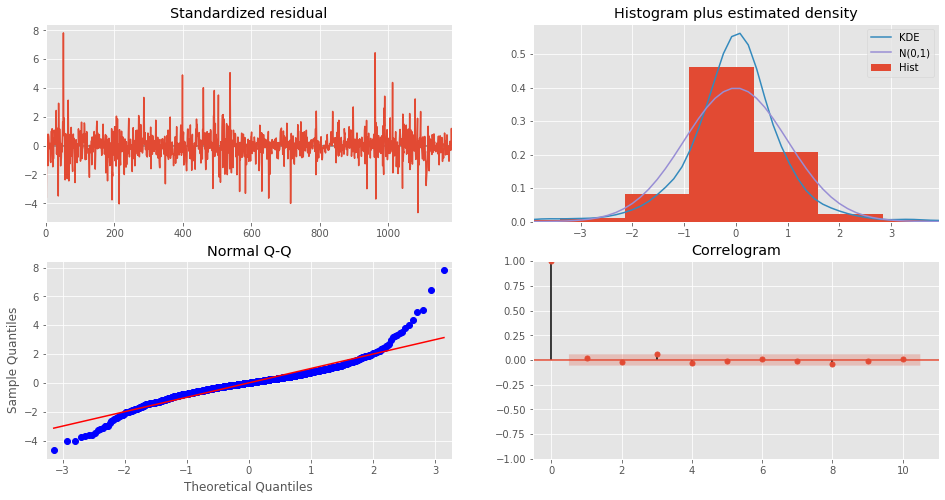

# --2-- build arima/sarima models and make one-step forcasting
                             ARIMA Model Results                              
Dep. Variable:            D.adj_close   No. Observations:                 1187
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2083.006
Method:                           css   S.D. of innovations              1.399
Date:                Thu, 18 Jun 2020   AIC                           4170.011
Time:                        09:49:59   BIC                           4180.170
Sample:                             1   HQIC                          4173.840
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0061      0.041     -0.149      0.881      -0.086       0.074
# --3-- Plot Forcasting


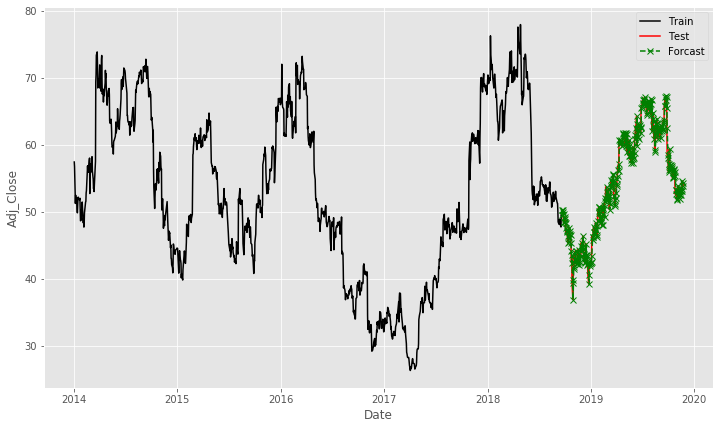

# --4-- Model Evaluation
          RMSE      MAPE     SMAPE    MinMax      Corr
Algo  1.258505  1.749915  1.747609  1.719983  0.986928


In [19]:
pm_params = auto_arima_kwargs.copy()
model, metric = my_auto_arima(data.adj_close, ntrain, pm_params)

# --1-- Using pm.auto_arima to find the model orders
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 23); AIC=4370.263, BIC=4395.565, Fit time=9.723 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 23); AIC=7915.340, BIC=7925.461, Fit time=0.175 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 23); AIC=4683.646, BIC=4703.888, Fit time=6.208 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 23); AIC=6710.532, BIC=6730.774, Fit time=5.795 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 23); AIC=4351.779, BIC=4382.142, Fit time=14.486 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 0, 23); AIC=4684.312, BIC=4709.615, Fit time=8.123 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 23); AIC=4362.132, BIC=4397.556, Fit time=76.616 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 23); AIC=4914.418, BIC=4934.659, Fit time=1.121 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 2, 23); AIC=4355.406, BIC=4395.8

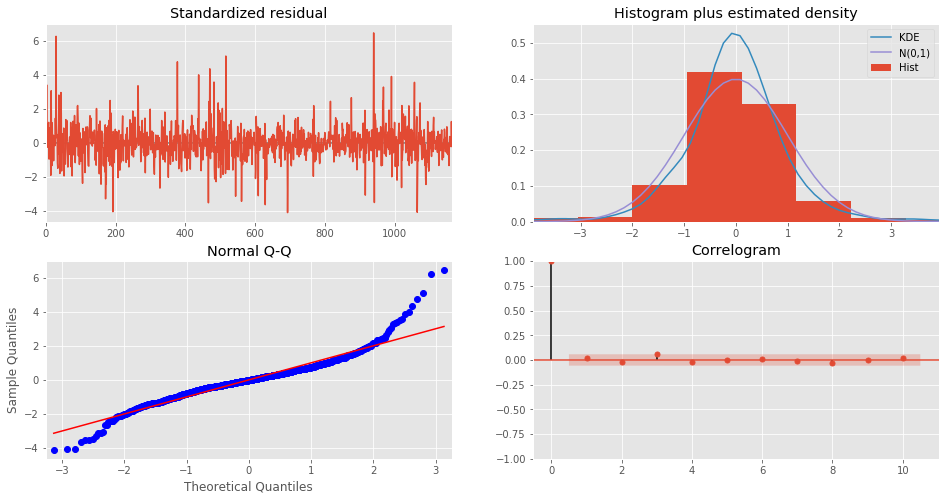

# --2-- build arima/sarima models and make one-step forcasting


In [ ]:
pm_params_s = auto_sarima_kwargs.copy()
pm_params_s['m'] = 23
pm_params_s['D'] = 1
model_s, metric_s = my_auto_arima(data.adj_close, ntrain, pm_params_s)